# Figure 2. Classifying DROSHA-dependent miRNAs
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-20.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210120/


In [4]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from scipy.stats import mannwhitneyu, sem, ttest_ind
from collections import defaultdict, Counter
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [6]:
s1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
s2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv', 
                 header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/TableS3__In_vitro_processing_results_Microprocessor-only.csv',
                 header=1, index_col=0)
s4 = pd.read_csv('supplementary/TableS4__Cis-acting_elements_of_human_pri-miRNAs.csv', 
                 header=1, index_col=0)

In [7]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [8]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [11]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
#mirtrons = s1[s1['DROSHA dependency'].apply(lambda x:x.find('Mirtron')>=0)].index
#droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
#fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
print len(drodep), len(droind)

311 257


In [12]:
EFFCUT = 1.5
HOMCUT = .25
effs = s3['Cleavage Efficiency'].to_dict()
homs = s3['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s3.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s3.index if m not in dcsmirs ]
print len(s3.index), len(dcsmirs), len(nodcs)

1816 560 1256


---

## A. Different cleavage patterns

In [13]:
inpraw = pd.read_csv('supplementary/TableSub__input_Microprocessor.csv',header=1,index_col=0)
inpsum = pd.DataFrame()
for inp in ['set1','set3','set5']:
    inpsum[inp] = inpraw[['%s-1'%inp,'%s-2'%inp]].sum(axis=1)
inpsum['set2'] = inpraw['set2']
inpsum['set4'] = inpraw['set4'] 
inpsum = inpsum[LIBRARIES]
inpsum.head(1)

,set1,set2,set3,set4,set5
Pri-miRNA,,,,,
hsa-let-7a-1,1373,474,0,2,0


In [21]:
clvraw = pd.read_csv('supplementary/TableSub__cleavage_products_Microprocessor.csv',
                     index_col=0).set_index(['Pri-miRNA','rstart','rend'])
clvraw.head()

pilot-1  pilot-2  set1-1  set1-2  set2-1  set2-2  \
Pri-miRNA    rstart rend                                                     
hsa-let-7a-1 1      8         0.0      0.0     2.0     2.0     4.0     0.0   
                    9         0.0      0.0     6.0     2.0     0.0     0.0   
                    10       55.0     26.0     4.0     4.0     0.0     1.0   
                    11       19.0     18.0     1.0     1.0     0.0     0.0   
                    12      606.0    314.0     5.0     3.0     0.0     0.0   

                          set3-1  set3-2  set4-1  set4-2  set5-1  set5-2  
Pri-miRNA    rstart rend                                                  
hsa-let-7a-1 1      8        0.0     0.0     0.0     0.0     0.0     0.0  
                    9        0.0     0.0     0.0     0.0     0.0     0.0  
                    10       0.0     0.0     0.0     0.0     0.0     0.0  
                    11       0.0     0.0     0.0     0.0     0.0     0.0  
                    12       0.0     0.0     0.0     0.0     0.0     0.0

In [22]:
clvtbl = pd.DataFrame()
for lib in LIBRARIES:
    clvtbl[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvtbl = clvtbl.reset_index()
clvtbl.head(1)

,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4.0,4.0,0.0,0.0,0.0


In [23]:
START, MID, END = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==START)&(clvtbl['rend']<MID)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>MID)&(clvtbl['rend']==END)].set_index('Pri-miRNA')

In [24]:
mirs = ['hsa-let-7a-1','hsa-mir-152','hsa-mir-320a']
lib = 'set2'

In [25]:
RCUTOFF = 30
clvinp = {}
for m in set(clv5f.index)&set(clv3f.index):
    ps, pe = preposition[m]
    inp = inpsum.loc[m,'set2']
    clv5 = clv5f.loc[[m]].set_index('rend').reindex(range(ps-4,ps+3))[lib].sum()
    clv3 = clv3f.loc[[m]].set_index('rstart').reindex(range(pe-2,pe+5))[lib].sum()
    if inp>=RCUTOFF:
        clvinp[m] = (clv5+clv3)/inp

In [26]:
norm = clvinp['hsa-let-7f-2']# np.percentile(clvinp.values(),95)
relq = { m:min(clvinp[m]/norm,1) for m in mirs }
relq

{'hsa-let-7a-1': 1,
 'hsa-mir-152': 0.8468779269270439,
 'hsa-mir-320a': 0.0009262575090915034}

In [27]:
[(m,clvinp[m]) for m in clvinp if abs(clvinp[m]-norm)<=.06 ]

[('hsa-mir-708', 4.2323759791122715),
 ('hsa-mir-376a-2', 4.249797242497973),
 ('hsa-let-7f-2', 4.25959367945824),
 ('hsa-mir-96', 4.289198606271777)]

In [28]:
for m in mirs:
    sum5 = clv5f.loc[m,lib].sum()
    sum3 = clv3f.loc[m,lib].sum()
    ps, pe = preposition[m]
    c5 = (clv5f.loc[m].set_index('rend')[lib]/sum5).reindex(range(ps-4,ps+3)).fillna(0)*100
    c3 = (clv3f.loc[m].set_index('rstart')[lib]/sum3).reindex(range(pe-2,pe+5)).fillna(0)*100
    print m, c5.round(1).tolist(), c3.round(1).tolist()

hsa-let-7a-1 [0.7, 0.8, 2.6, 93.6, 0.2, 0.0, 0.0] [0.0, 0.0, 0.0, 97.3, 1.2, 0.0, 0.4]
hsa-mir-152 [1.5, 4.6, 39.0, 40.2, 0.1, 0.0, 0.1] [0.0, 0.0, 0.0, 46.5, 48.0, 0.2, 0.3]
hsa-mir-320a [3.0, 9.1, 0.0, 0.0, 3.0, 3.0, 6.1] [0.7, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0]


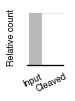

In [29]:
m = mirs[2]
fig, ax = plt.subplots(1, 1, figsize=(.65,1))
ax.bar([0,1],[1,relq[m]],color='#bababa',width=.7)
ax.spines['left'].set_visible(False)
ax.set_xticks(np.array([0,1])-.2)
ax.set_xticklabels(['Input','Cleaved'],fontsize=9,rotation=25)
ax.set_yticklabels([])
ax.yaxis.grid(ls='-',lw=.5)
ax.set_ylabel('Relative count',fontsize=9)
ax.tick_params(bottom='off',left='off')
#fig.savefig(resultpath+'201229_f2a__example_%s.pdf'%m)

## S2A-B. Precision-Recall

In [30]:
def get_precision(cutoff, mirl, data, pcs):
    tpos = [m for m in mirl if m in pcs and data[m]>=cutoff]
    pos = [m for m in mirl if data[m]>=cutoff]
    return len(tpos)/len(pos)

In [31]:
def get_recall(cutoff, mirl, data, pcs):
    tpos = [m for m in mirl if m in pcs and data[m]>=cutoff]
    return len(tpos)/len(pcs)

In [32]:
testset = [ mir for mir in s3.index if mir in drodep or mir in droind ]
pcs = [ mir for mir in s3.index if mir in drodep ]
print len(testset), len(pcs)

560 305


In [33]:
erange = np.arange(0,3.1,.3)
eprs = [ get_precision(e,testset,effs,pcs) for e in erange ]
ercs = [ get_recall(e,testset,effs,pcs) for e in erange ]

In [34]:
hrange = np.arange(0,.71,.05)
hprs = [ get_precision(e,testset,homs,pcs) for e in hrange ]
hrcs = [ get_recall(e,testset,homs,pcs) for e in hrange ]

In [35]:
ecut = 1.5
hcut = .25
ex = get_recall(ecut,testset,effs,pcs)
ey = get_precision(ecut,testset,effs,pcs)
hx = get_recall(hcut,testset,homs,pcs)
hy = get_precision(hcut,testset,homs,pcs)
print ex,ey,hx,hy

0.724590163934 0.965065502183 0.777049180328 0.963414634146


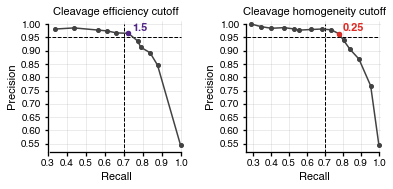

In [36]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,2.4))
ax1.errorbar(ercs,eprs,ms=4,marker='o',zorder=2,color='#424242')
ax2.errorbar(hrcs,hprs,ms=4,marker='o',zorder=2,color='#424242')
ax1.set_title('Cleavage efficiency cutoff',fontsize=11)
ax2.set_title('Cleavage homogeneity cutoff',fontsize=11)
for ax,xmin in zip([ax1,ax2],[ercs[-1],hrcs[-1]]):
    ax.spines['left'].set_bounds(.52,1)
    ax.spines['bottom'].set_bounds(xmin-.03,1)
    ax.set_xlim(xmin-.03,1.02)
    ax.set_ylim(.52,1.01)
    ax.set_xlabel('Recall',fontsize=11)
    ax.set_ylabel('Precision',fontsize=11)
    ax.set_xticks(np.arange(.3,1.1,.1))
    ax.set_yticks(np.arange(.55,1.05,.05))
    sq = plt.Rectangle([xmin-.03,.35],1.04-xmin,.66,fc='w'); ax.add_patch(sq)
    ax.grid(ls='-',lw=.5,clip_path=sq,which='both')
    ax.tick_params(labelsize=10)
ax1.text(ex+.02,ey+.01,ecut,fontsize=11,weight='bold',color='#502585')  
ax2.text(hx+.02,hy+.01,hcut,fontsize=11,weight='bold',color='#de2d26')
ax1.scatter([ex],[ey],s=20,color='#502585',zorder=3)
ax2.scatter([hx],[hy],s=20,color='#de2d26',zorder=3)
ax1.plot([0,1],[.95,.95],'k--',lw=1); ax1.plot([.7,.7],[0,1],'k--',lw=1)
ax2.plot([0,1],[.95,.95],'k--',lw=1); ax2.plot([.7,.7],[0,1],'k--',lw=1)
fig.subplots_adjust(wspace=.45)
#fig.savefig(resultpath + '210118_s2a__precision_recall.pdf')#,dpi=300)

## B.  Cleavage Efficiency and Cleavage Homogeneity

In [101]:
mirls = [ [m for m in s3.index if m in drodep], 
          [m for m in s3.index if m in droind],
          [m for m in s3.index if m not in list(drodep)+list(droind)] ]
xsl = [ [effs[m] for m in ml] for ml in mirls ]
ysl = [ [homs[m] for m in ml] for ml in mirls ]
fcolors = [ '#1b9e77', '#666666', '#cbcbcb' ]
ecolors = [ '#018571', '#353535','#bababa' ]
labels = [ 'DRO-dep.', 'DRO-ind.', 'Not yet determined' ]
sizes = [ 15, 15, 10 ]
zs = [ 4, 4, 3 ]
xmin, xmax, xo = 0, 4.5, .15
ymin, ymax, yo = 0, 1, .03
xcut, ycut = 1.5, .25
shade = '#a1d99b'
print map(len,mirls)

[305, 255, 1256]


In [38]:
for m in ['hsa-let-7a-1','hsa-mir-152','hsa-mir-320a']:
    print m, effs[m], homs[m]

hsa-let-7a-1 4.05131059336 0.882549482661
hsa-mir-152 3.77929225238 0.503726361264
hsa-mir-320a 0.0334805808999 0.0707050429844


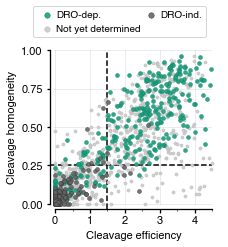

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
for xs,ys,fc,ec,label,s,z in zip(xsl,ysl,fcolors,ecolors,labels,sizes,zs):
    xs,ys = zip(*[ (x,y) for x,y in zip(xs,ys) if xmin<=x<xmax and ymin<=y<ymax])
    ax.scatter(xs, ys, s=s, color=fc, edgecolor=ec, lw=.5, zorder=z, label=label, alpha=.9,
              rasterized=True)
ax.plot([xmin-xo,xmax],[ycut,ycut],'k--',zorder=2)
ax.plot([xcut,xcut],[ymin-yo,ymax],'k--',zorder=2)

ax.set_xlabel('Cleavage efficiency',fontsize=11)
ax.set_ylabel('Cleavage homogeneity',fontsize=11)
ax.set_xticks(np.arange(xmin,xmax+xo,.5),minor=True)
ax.set_yticks(np.arange(ymin,ymax+yo,.25))
ax.set_xlim(xmin-xo, xmax+xo)
ax.set_ylim(ymin-yo, ymax+yo)
ax.spines['bottom'].set_bounds(xmin, xmax)
ax.spines['left'].set_bounds(ymin, ymax)

handles, labels = ax.get_legend_handles_labels()
handles = [ handles[0],handles[2],handles[1] ]; labels = [ labels[0],labels[2],labels[1]]
leg = ax.legend(handles,labels,loc=(-.1,1.05), handletextpad=-.1, ncol=2, columnspacing=.05)
for handle in leg.legendHandles:
    handle.set_sizes([30])

gr = plt.Rectangle((xmin-xo/4,ymin-yo/4), xmax+xo/4, ymax+yo/4, fc='w'); ax.add_patch(gr)
ax.grid(ls='-', lw=.5, clip_path=gr)
#fig.savefig(resultpath + '210118_f2b__cleavage_pattern.pdf',dpi=300)

In [40]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s3.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

560 (25, 96)


## C. Productively processed miRNAs

[560, 1256] [30.83700441 69.16299559]


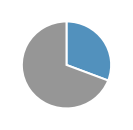

In [42]:
data = map(len, [dcsmirs, nodcs])
print data, np.array(data)/len(s3.index)*100
colors = '#5291bd #969696'.split()
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ps,ts = ax.pie(data, colors=colors, wedgeprops={'linewidth':2,'edgecolor':'w'},
               startangle=90,counterclock=False)
fig.savefig(resultpath + '210112_f2c__productive_processing.pdf')

In [43]:
ys1 = [ len([m for m in s3.index if m in ml and m in nodcs])/len(ml)*100 for ml in mirls[:2] ]
ys2 = [ len([m for m in s3.index if m in ml and m in dcsmirs])/len(ml)*100 for ml in mirls[:2] ]
print ys1, ys2

[29.508196721311474, 99.2156862745098] [70.49180327868852, 0.7843137254901961]


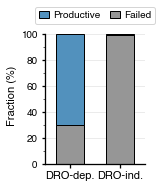

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(1.8,2.5))
ax.bar(range(2),ys1,color=colors[1],width=.55,label='Failed',zorder=2,lw=1,edgecolor='k')
ax.bar(range(2),ys2,bottom=ys1,color=colors[0],width=.55,label='Productive',zorder=2,
      lw=1,edgecolor='k')
ax.set_xlim(-.5,1.5)
ax.set_xticks(range(2))
ax.set_xticklabels(['DRO-dep.','DRO-ind.'])
ax.spines['left'].set_bounds(0,100)
ax.set_yticks(range(0,101,10),minor=True)
ax.set_yticklabels(range(0,101,20),fontsize=10)
ax.set_ylabel('Fraction (%)')
ax.yaxis.grid(ls='-',lw=.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],labels[::-1],handlelength=1,handletextpad=.4,loc=(-.1,1.03),
         ncol=2,columnspacing=1)
#fig.savefig(resultpath + '210118_s2__fnr_fpr.pdf')

## S2D. Alternative processing

In [45]:
ms = [ m for m in s3.index if effs[m]>=EFFCUT]
xs = s3.reindex(ms)['Cleavage Homogeneity']
ys = s3.reindex(ms)['Cleavage ratio of alternative site'].fillna(0)
xs2 = s3.reindex(['hsa-mir-152','hsa-mir-342'])['Cleavage Homogeneity']
ys2 = s3.reindex(['hsa-mir-152','hsa-mir-342'])['Cleavage ratio of alternative site'].fillna(0)

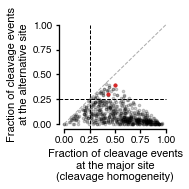

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.scatter(xs,ys,s=7,color='k',alpha=.2,rasterized=True)
ax.scatter(xs2,ys2,s=10,color='tab:red',rasterized=True)
ax.set_xlabel('Fraction of cleavage events\nat the major site\n(cleavage homogeneity)')
ax.set_ylabel('Fraction of cleavage events\nat the alternative site')
ax.set_xlim(-.05,1.05)
ax.set_ylim(-.05,1.05)
ax.plot([0,1],[0,1],'#ababab',lw=1,ls='--')
ax.plot([-.05,1],[.25,.25],color='k',lw=1,ls='--')
ax.plot([.25,.25],[-.05,1],color='k',lw=1,ls='--')
ax.set_xticks(np.arange(0,1.1,.25))
ax.set_yticks(np.arange(0,1.1,.25))
ax.spines['bottom'].set_bounds(0,1)
ax.spines['left'].set_bounds(0,1)
ax.tick_params(labelsize=10)
#fig.savefig(resultpath + '210118_s2c_alternative.pdf',dpi=300)

## D. Validation of classification results - secondary structure

In [48]:
bpfreq5 = pd.DataFrame(index=s3.index, columns=range(-30,30))
bpfreq3 = pd.DataFrame(index=s3.index, columns=range(-30,30))
for mir in s3.index:
    if mir in dcsmirs:
        ps,pe = majorcs[mir]
    else:
        ps,pe = preposition[mir]
    sts = [(i,1) if s=='M' else (i,0) for i,s in enumerate(s4.loc[mir,'Secondary structure'])]
    bpfreq5.loc[mir] = pd.Series({i-ps+1:p for i,p in sts})
    bpfreq3.loc[mir] = pd.Series({pe-i-1:p for i,p in sts})
print len(bpfreq5)

1816


In [49]:
mirls = [ dcsmirs, nodcs ]
xmin, xmax = -20, 25
xs = np.arange(xmin,xmax)
ysl = [[bpfreq5.reindex(ml)[x].dropna().mean()*100 for x in xs] for ml in mirls]
ys2 = (np.array(ysl[0])-np.array(ysl[1]))
labels = [ 'Productive', 'Failed' ]
colors = '#5291bd #969696'.split()
zs = [ 4,3,3 ]

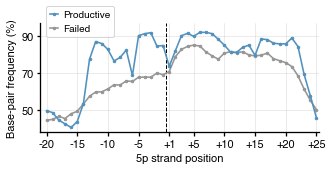

In [50]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,2))
for ys,c,label,z,ml in zip(ysl,colors,labels,zs,mirls)[:2]:
    ax1.errorbar(xs,ys,color=c,label=label,ms=2.5,marker='o',lw=1.6,zorder=z)


ax1.set_xlim(xmin-1, xmax-.5)
ax1.set_xticks([-20,-15,-10,-5,0,4,9,14,19,24])
ax1.set_xticklabels([-20,-15,-10,-5,'+1','+5','+10','+15','+20','+25'])
ax1.grid(ls='-',lw=.5)
ax1.set_ylim(38,97)
ax1.set_yticks([50,70,90])
ax1.set_xlabel('5p strand position')
ax1.set_ylabel('Base-pair frequency (%)')
ax1.axvline(-.5,color='k',ls='--',lw=1)
ax1.legend(loc=(.02,.87), handlelength=.8, handletextpad=.5)
#fig.savefig(resultpath + '210112_f2d__structure.pdf')#,dpi=300)

## S2F. Loop size

In [52]:
data = [[get_new_str(m).count('L') for m in dcsmirs],
        [get_new_str(m).count('L') for m in nodcs]]
colors = '#5291bd #757575'.split()
print map(len,data)
print ttest_ind(data[0],data[1])

[560, 1256]
Ttest_indResult(statistic=1.46839488440292, pvalue=0.14217036564701943)


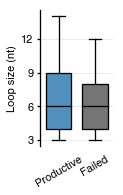

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(1.3,2.5))
bp = ax.boxplot(data,widths=.7,sym='',boxprops={'linewidth':1.3},
                medianprops={'color':'black','linewidth':1.3}, capprops={'linewidth':1.3},
                whiskerprops={'linewidth':1.3}, patch_artist=True,zorder=2,whis=1)
for box,c in zip(bp['boxes'],colors):
    box.set_facecolor(c)

ax.set_xticks([1,2])
ax.set_xticklabels(['Productive','Failed'],rotation=30)
ax.set_yticks([3,6,9,12])
ax.set_ylabel('Loop size (nt)',fontsize=11)
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom='off')
ax.yaxis.grid(ls='-',lw=.5)
fig.savefig(resultpath + '210112_s2__loop_size.pdf')

## S2G. Parameterization of lower stem

In [54]:
xs = range(1,14)
ys1 = [ len([m for m in dcsmirs if bpfreq5.loc[m,range(-13,0)].sum()==x])/len(dcsmirs)*100
        for x in xs ]
ys2 = [ len([m for m in nodcs if bpfreq5.loc[m,range(-13,0)].sum()==x])/len(nodcs)*100
        for x in xs ]
print ys1, ys2

[0.35714285714285715, 0.0, 0.0, 0.8928571428571428, 0.8928571428571428, 1.607142857142857, 1.4285714285714286, 3.392857142857143, 10.0, 14.642857142857144, 25.0, 28.749999999999996, 13.035714285714286] [0.9554140127388535, 2.1496815286624202, 2.945859872611465, 2.8662420382165608, 4.219745222929936, 4.777070063694268, 8.04140127388535, 10.987261146496815, 12.898089171974522, 13.614649681528663, 13.455414012738853, 12.261146496815286, 5.095541401273886]


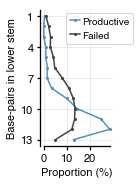

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(1.3,2.5))
ax.errorbar(ys1,xs,ms=2,marker='o',zorder=2,color='#5291bd',label='Productive')
ax.errorbar(ys2,xs,ms=2,marker='o',zorder=2,color='#424242',label='Failed')
ax.invert_yaxis()
ax.set_ylabel('Base-pairs in lower stem')
ax.set_xlabel('Proportion (%)')
ax.set_yticks([1,4,7,10,13])
ax.set_xticks([0,10,20])
ax.spines['bottom'].set_bounds(0,29)
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=1,handletextpad=.2,loc=(.35,.75))
#ax.axhline(10,color='k',ls='--',lw=1,zorder=1)
#fig.savefig(resultpath + '210112_s2__bp_LS.pdf')

## E. Validation of classification results - sequence motifs

In [56]:
seq5tbl, seq3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))
str5tbl, str3tbl = pd.DataFrame(columns=range(-20,30)), pd.DataFrame(columns=range(-25,30))

In [57]:
for mir in s3.index:
    if mir in dcsmirs:
        ps, pe = majorcs[mir]
    else:
        ps, pe = preposition[mir]
    priseq = constseqs[mir].replace('T','U')
    strt = [ 1 if s=='M' else 0 for s in s4.loc[mir,'Secondary structure'] ]
    seq5, str5 = priseq[max(0,ps-21):ps+29][::-1], strt[max(0,ps-21):ps+29][::-1]
    seq3, str3 = priseq[pe-30:min(125,pe+25)], strt[pe-30:min(125,pe+25)]
    pos5, pos3 = range(-20,30)[::-1], range(-25,30)[::-1]
    seq5tbl.loc[mir] = pd.Series(dict(zip(pos5,seq5)[::-1]))
    seq3tbl.loc[mir] = pd.Series(dict(zip(pos3,seq3)[::-1]))
    str5tbl.loc[mir] = pd.Series(dict(zip(pos5,str5)[::-1]))
    str3tbl.loc[mir] = pd.Series(dict(zip(pos3,str3)[::-1]))

In [58]:
seq5tbl = seq5tbl.fillna('')
str5tbl = str5tbl.fillna('')
seq3tbl = seq3tbl.fillna('')
str3tbl = str3tbl.fillna('')

In [59]:
def count_len(symstr):
    return sum([symstr.count(s) for s in 'MS'])

In [60]:
def find_ug(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+2)].fillna(''))
    return seq=='UG'

In [72]:
def find_ugu(mir, pos):
    seq = ''.join(seq5tbl.loc[mir,range(pos,pos+3)])
    return (seq=='UGU' or seq=='GUG')

In [62]:
def find_cnnc(mir, pos):
    seq = ''.join(seq3tbl.loc[mir,range(pos-3,pos+1)].fillna(''))
    return bool(re.search('C[A-Z][A-Z]C', seq))

In [63]:
scotbl = pd.ExcelFile('supplementary/Kwon_2018_s4.xlsx').parse('DODGERS scores',header=5,
                                                              index_col=2)
scotbl.head(3)

,5p arm (5' to 3'),3p arm (3' to 5'),DODGERS score
DODGERS motif,,,
UGCGCG,UGC,GCG,100.000000
UACGUG,UAC,GUG,99.309250
CUCGCG,CUC,GCG,95.926412


In [64]:
def matching_bases(st, en, symstr):
    str5p = symstr[st-1:]
    str3p = symstr[:en][::-1]
    i,j = 0,0
    match = {}
    while i<len(str5p) and j<len(str3p):
        if str5p[i]=='L' or str3p[j]=='L':
            break
        if str5p[i]!='A' and str3p[j]!='A':
            match[i]=j; i+=1; j+=1
        elif str5p[i]=='A':
            i+=1
        elif str3p[j]=='A':
            j+=1
    return {i+st:en-j for i,j in match.items()}        

In [65]:
def get_ghgs(mir):
    symstr = s4.loc[mir, 'Secondary structure']
    bjs = symstr.find('M')+1
    bje = symstr.rfind('M')+1
    matches = matching_bases(bjs,bje,symstr)
    priseq = constseqs[mir].replace('T','U')
    if mir in dcsmirs:
        ps = majorcs[mir][0]
    else:
        ps = preposition[mir][0]
    if len(matches)<3:
        return {}
    end = sorted(matches.keys())[-3]
    ghgs = {}
    for st in range(bjs,end+1):
        if st not in matches:
            continue
        if all([((st+i),(matches[st]-i)) in matches.items() for i in range(3)]):
            if st<ps:
                pos = -count_len(symstr[st-1:ps-1])
            else:
                pos = count_len(symstr[ps-1:st-1])
            ghg5p = priseq[st-1:st+2]
            ghg3p = priseq[matches[st]-3:matches[st]][::-1]
            ghgseq = ghg5p+ghg3p
            ghgs[pos+1] = scotbl.loc[ghgseq,'DODGERS score']
    return ghgs

In [66]:
ghgtbl = {}
for mir in s2.index:
    ghgtbl[mir] = get_ghgs(mir)
ghgtbl = pd.DataFrame(ghgtbl).T

In [67]:
GHGCUT = 38
def find_ghg(mir, pos): 
    return (ghgtbl.loc[mir,pos-1]>=GHGCUT)

In [73]:
motifs = [ 'CNNC', 'UG', 'GHG', 'UGU' ]
ranges = { 'UG':range(-15,-12),'UGU':range(20,23),'GHG':range(-6,-3), 'CNNC':range(-18,-15) }
funcs = { 'UG':find_ug, 'UGU':find_ugu, 'GHG':find_ghg, 'CNNC':find_cnnc }

In [70]:
basals = {}
allseqs = constseqs.values()
for motif,r in zip(motifs,['C[A-Z][A-Z]C','TG','[A-Z][^G]G','TGT|GTG']):
    if motif=='GHG':
        allcase = ghgtbl.apply(lambda x:x>=GHGCUT).sum().sum()
        total = sum([s4.loc[m,'Secondary structure'].find('L')\
                     -s4.loc[m,'Secondary structure'].find('M')-1 for m in s2.index])
        basals[motif] = allcase/total
    else:
        l = len(motif)
        allcase = sum([bool(re.search(r,s[i:i+l])) for i in range(125-l+1) for s in allseqs])
        basals[motif] = allcase/len(allseqs)/(125-l+1)
print basals

{'UG': 0.0848167584160793, 'GHG': 0.27494183965640656, 'UGU': 0.04325237829730769, 'CNNC': 0.06631456933441403}


In [74]:
ysd = defaultdict(list)
for motif in motifs:
    for i,pos in enumerate(ranges[motif]):
        l = []
        for mir in s3.index:
            if funcs[motif](mir,pos):
                l.append(mir)
        ysd[motif].append(l)

In [75]:
mirls =  [ dcsmirs, nodcs ]
labels = [ 'Productive', 'Unproductive' ]
arms = { 'UG':'5p', 'UGU':'5p', 'GHG':'3p', 'CNNC':'3p' }
cmap = custom_cmap(['#404040','#f0f0f0','#f0f0f0','#de2d26'], nspace=3)

In [76]:
entbls = defaultdict(lambda: pd.DataFrame())
for motif in motifs:
    basal = basals[motif]
    for mirl,label in zip(mirls,labels):
        for j in range(len(ysd[motif])):
            freq = len([m for m in mirl if m in ysd[motif][j]])/len(mirl)
            entbls[motif].loc[label,ranges[motif][j]] = np.log2(freq/basal)

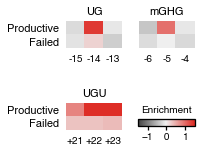

In [78]:
fig = plt.figure(figsize=(2.3,2))
gs = gridspec.GridSpec(2, 2)
axes = [ fig.add_subplot(gs[i]) for i in range(4) ]
for motif,ax in zip(['UG','GHG','UGU','CNNC'],axes):
    im = ax.pcolor(entbls[motif],cmap=cmap,vmax=1.5,vmin=-1.5)
    ax.set_xticks(np.arange(len(ranges[motif]))+.5)
    ax.set_xticklabels([i if i<0 else '+%s'%(i+1) for i in ranges[motif]],fontsize=10)
    ax.tick_params(left='off',bottom='off')
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    motifn = motif.replace('GHG','mGHG')
    #ax.set_title('%s (%s)'%(motifn,arms[motif]),fontsize=11)
    ax.set_title(motifn,fontsize=11)
    ax.set_yticks([])
    ax.invert_yaxis()

for ax in [axes[0],axes[2]]:
    ax.set_yticks(np.arange(len(mirls))+.5)
    ax.set_yticklabels(['Productive','Failed'], fontsize=11)
axcb = fig.add_axes([.56,.15,.34,.05])
cb = plt.colorbar(im, cax=axcb, orientation='horizontal')
cb.set_ticks([-1,0,1]); cb.solids.set_rasterized(True); axcb.tick_params(labelsize=10)
fig.delaxes(axes[3])
fig.text(.73,.24,'Enrichment',ha='center',fontsize=10)
fig.subplots_adjust(wspace=.3,hspace=2)
#fig.savefig(resultpath + '210112_f2e__primary_sequence_motif.pdf')#,dpi=300)

## F. Combination analysis

In [85]:
ranges = { 'UG':[-14],'UGU':range(20,25),'GHG':[-5], 'CNNC':range(-18,-15) }
motmirs = {}
for motif in motifs:
    ml = []
    for mir in s3.index:
        for pos in ranges[motif]:
            if funcs[motif](mir,pos):
                ml.append(mir)
                break
    print motif, len(ml)
    motmirs[motif] = ml

CNNC 623
UG 250
GHG 647
UGU 455


In [100]:
len([m for m in s3.index if 'LS' in mirmot[m]])

826

In [87]:
mirmot = defaultdict(list)
for mir in dcsmirs+nodcs:
    if bpfreq5.loc[mir,range(-13,0)].sum()>=10 and bpfreq3.loc[mir,range(-11,0)].sum()>=8:
        mirmot[mir].append('LS')
    if mir in motmirs['GHG']:
        mirmot[mir].append('GHG')
    if mir in motmirs['UG']:
        mirmot[mir].append('UG')
    if mir in motmirs['UGU']:
        mirmot[mir].append('UGU')

In [88]:
com0 = [ [] ]
com1 = [ ['LS'], ['GHG'], ['UG'], ['UGU'] ]
com2 = [ ['LS','GHG'],['LS','UG'],['LS','UGU'],['GHG','UG'],['GHG','UGU'],['UG','UGU'] ]
com3 = [ ['LS','GHG','UG'],['LS','GHG','UGU'],['LS','UG','UGU'],['GHG','UG','UGU'] ]
com4 = [ ['LS','GHG','UG','UGU'] ]
comall =  com0+com1+com2+com3+com4
for com in comall:
    cnt1 = len([ mir for mir in dcsmirs if mirmot[mir]==com])
    cnt2 = len([ mir for mir in nodcs if mirmot[mir]==com])
    print ' '.join(com), cnt1, cnt2

 46 479
LS 88 178
GHG 27 139
UG 7 46
UGU 29 128
LS GHG 109 121
LS UG 22 21
LS UGU 41 41
GHG UG 7 15
GHG UGU 17 26
UG UGU 6 13
LS GHG UG 40 16
LS GHG UGU 78 19
LS UG UGU 17 7
GHG UG UGU 2 3
LS GHG UG UGU 24 4


In [90]:
mirl = s3.index
sortcom = sorted(comall,key=lambda x:np.average([effs[m] for m in mirl if mirmot[m]==x]),
                 reverse=True)
sortcom = [ com for com in sortcom if len([m for m in mirl if mirmot[m]==com])>=5 ]
ys1 = [ len([m for m in mirl if mirmot[m]==com]) for com in sortcom ]

mirls = [ [m for m in mirl if mirmot[m]==com] for com in sortcom ]
xs = range(len(sortcom))
ys2 = [ np.average([effs[m] for m in ml]) for ml in mirls ]
ye2 = [ sem([effs[m] for m in ml]) for ml in mirls ]
ys3 = [ np.average([homs[m] for m in ml]) for ml in mirls ]
ye3 = [ sem([homs[m] for m in ml]) for ml in mirls ]

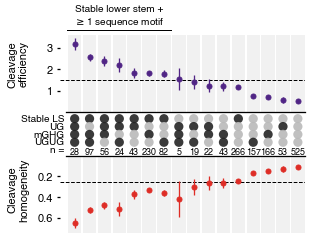

In [98]:
fig = plt.figure(figsize=(4.4,3.8))
gs = gridspec.GridSpec(5,1)
ax1 = plt.subplot2grid((5,1),(0,0),colspan=1,rowspan=2)
ax2 = plt.subplot2grid((5,1),(2,0),colspan=1,rowspan=1)
ax3 = plt.subplot2grid((5,1),(3,0),colspan=1,rowspan=2)
fig.subplots_adjust(hspace=.04, wspace=.35)

sortmot = ['LS','UG','GHG','UGU']
l = len(motifs)
for i, (mots,cnt) in enumerate(zip(sortcom,ys1)):
    colors = [ '#242424' if mot in mots else '#bababa' for mot in sortmot ]
    ax2.scatter([i]*l, range(l), s=85, color=colors, alpha=.9, linewidth=0)
    ax2.text(i,4.5,cnt,ha='center',fontsize=9)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylim(-.6,4.5)
ax2.invert_yaxis()
ax2.set_xticks([]); ax2.set_yticks([])
for i,txt in zip(range(5),['Stable LS','UG','mGHG','UGUG','n =']):
    ax2.text(-.7,i,txt,va='center',ha='right',fontsize=10)

for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-1,len(xs)-.5)
    ax.tick_params(bottom='off')
    
ax1.text(-3.8,2.25,'Cleavage\nefficiency',va='center',rotation=90,fontsize=11,ha='center')
ax3.text(-3.8,.325,'Cleavage\nhomogeneity',va='center',rotation=90,fontsize=11,ha='center')
ax1.set_yticks([1,2,3])
ax3.set_yticks([.2,.4,.6])
ax3.axhline(.25,color='k',ls='--',lw=1)
ax1.axhline(1.5,color='k',ls='--',lw=1)
ax1.errorbar(xs,ys2,yerr=ye2,ms=5,marker='o',lw=0,elinewidth=1.3,color='#502585',zorder=3)
ax3.errorbar(xs,ys3,yerr=ye3,ms=5,marker='o',lw=0,elinewidth=1.3,color='#de2d26',zorder=3)
ax1.bar(xs,[3.6]*len(xs),width=.9,color='#bcbcbc',alpha=.2)
ax3.bar(xs,[.75]*len(xs),width=.9,color='#bcbcbc',alpha=.2)
for ax in [ax1,ax3]:
    ax.set_xticks([])
    ax.spines['left'].set_visible(False)
ax1.spines['bottom'].set_bounds(-.6,len(xs)-.5)
ax3.spines['top'].set_bounds(-.6,len(xs)-.5)
ax3.invert_yaxis()
ax3.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(True)
l = lines.Line2D([-.5,6.5],[3.8,3.8],lw=1,color='k')
ax1.text(3,4,'Stable lower stem +\n$\geq$1 sequence motif',ha='center')
ax1.add_line(l); l.set_clip_on(False)
fig.savefig(resultpath + '210112_f2f__combination.pdf')#,dpi=300)